# DSP experiments

This notebook contains DSP experiments to assess the accuracy of confidence level classification of climate statements by various LLMs.

In [1]:
# try: 
#     # This library is our indicator that the required installs
#     # need to be done.
#     import datasets
#     root_path = '.'
# except ModuleNotFoundError:
#     !git clone https://github.com/cgpotts/cs224u/
#     !pip install -r cs224u/requirements.txt
#     root_path = 'dsp'

Now we import modules to work with DSP, OpenAI, HuggingFace, and Cohere models

In [2]:
import pandas as pd 
# import cohere
from datasets import load_dataset
import openai
import re
import os
import dsp
import transformers

c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we import key variables such as API keys. Steps:

1) Create a keys.txt file in the root of your /content/ folder in the Colab instance

2) Define the API keys you will use 

3) Run the cell below to import the file

In [3]:
# Read the contents of the file
# with open('/content/keys.txt', 'r') as file:
#     file_contents = file.read()

# # Assign the variables
# exec(file_contents)

# os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(root_path, 'cache')
# openai_key = OPENAI_API_KEY  
# cohere_key = COHERE_API_KEY  

# OpenAI API
from getpass import getpass
import os
import openai
from openai import OpenAI

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file
new_api_key = getpass()

os.environ["OPENAI_API_KEY"] = new_api_key
openai.api_key = os.environ['OPENAI_API_KEY']
openai_key = openai.api_key
openai_client = OpenAI()

## Model setting

Now we define a choice of LM and setup the DSP environment.

In [4]:
# [d["root"] for d in openai.Model.list(api_key=openai_key)["data"]]

In [5]:
## Define the mode (uncomment appropriate line)

# lm = dsp.GPT3(model = "gpt-3.5-turbo", api_key=openai_key, model_type="chat")
lm = dsp.GPT3(model = "gpt-4-turbo", api_key=openai_key, model_type="chat")
#lm = dsp.Cohere(model = "command-xlarge-nightly", api_key=cohere_key)

dsp.settings.configure(lm=lm)
dsp.settings.show_guidelines = True

### Loading the dataset
Upload a tab separated version of the dataset to /content/.

In [6]:
df = pd.read_csv('ipcc_statements_dataset.tsv', sep='\t', skiprows=0)

train_set = df.loc[df['split'] == 'train']
test_set = df.loc[df['split'] == 'test']

test_set.tail

<bound method NDFrame.tail of       statement_idx     report  page_num  sent_num  \
3                 3    AR6_WGI        24         2   
42               42    AR6_WGI        37        16   
77               77    AR6_WGI        47         7   
81               81    AR6_WGI        62         2   
86               86    AR6_WGI        63         8   
...             ...        ...       ...       ...   
8024           8024  AR6_WGIII      1827        13   
8056           8056  AR6_WGIII      2011         5   
8067           8067  AR6_WGIII      2012         8   
8086           8086  AR6_WGIII      2016         8   
8093           8093  AR6_WGIII      2058        21   

                                              statement confidence  score  \
3     Since 1750, increases in CO2 (47%) and CH4 (15...  very high      3   
42    Over the next 2000 years, global mean sea leve...        low      0   
77    By the end of the century, scenarios with very...       high      2   
81    Over th

In [7]:
ipcc_train = [dsp.Example(input=row['statement'], label=row['confidence'], score=row['score'], report=row['report'])
                    for _, row in train_set.iterrows()]

In [8]:
ipcc_train[:5]

[{'input': 'Since 2011 (measurements reported in AR5), concentrations have continued to increase in the atmosphere, reaching annual averages of 410 parts per million (ppm) for carbon dioxide (CO 2), 1866 parts per billion (ppb) for methane (CH 4), and 332 ppb for nitrous oxide (N 2O) in 2019.6 Land and ocean have taken up a near-constant proportion (globally about 56% per year) of CO 2 emissions from human activities over the past six decades, with regional differences',
  'label': 'high',
  'score': 2,
  'report': 'AR6_WGI'},
 {'input': 'Mid-latitude storm tracks have likely shifted poleward in both hemispheres since the 1980s, with marked seasonality in trends',
  'label': 'medium',
  'score': 1,
  'report': 'AR6_WGI'},
 {'input': 'The average rate of sea level rise was 1.3 [0.6 to 2.1] mm yr–1 between 1901 and 1971, increasing to 1.9 [0.8 to 2.9] mm yr–1 between 1971 and 2006, and further increasing to 3.7 [3.2 to 4.2] mm yr–1 between 2006 and 2018',
  'label': 'high',
  'score': 2,

### Perform checks on dataset


In [9]:
print(len(ipcc_train))
print(len([ex for ex in ipcc_train if ex.label=='low']))
print(len([ex for ex in ipcc_train if ex.report=='AR6_WGIII']))
print(len([ex for ex in ipcc_train if ex.score==2]))

7794
241
826
4611


## Split train set by confidence level

In [10]:
train_ex = {}
for confidence in ['low', 'medium', 'high', 'very high']: 
  train_ex[confidence] = [ex for ex in ipcc_train if ex.label==confidence]
  print(f"{confidence}: {len(train_ex[confidence])}")

low: 241
medium: 2415
high: 4611
very high: 527


## Defining templates

### Few-shot learning
Testing how models do on the task with demonstrations.

In [11]:
Input = dsp.Type(
    prefix="Statement:", 
    desc="${a short statement about climate.}")

Label = dsp.Type(
    prefix="Confidence: ", 
    desc="${must be *only*: 'low', 'medium', 'high', 'very high'}")

few_shot_template = dsp.Template(
    instructions="You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change. \
      \n\nYou will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?  \
      \n\nRespond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.",
    input=Input(),
    label=Label())

### Semantic Search (Few-shot statements)

In [12]:
import json

In [13]:
samples = train_set.copy()

In [14]:
select_col = ['statement', 'confidence', 'score', 'report']
samples = samples[select_col]
samples.rename(columns={'statement': 'input', 'confidence': 'label'}, inplace=True)

In [15]:
samples_dict = samples.to_dict(orient='records')

In [16]:
json_list = [json.dumps(row, indent=4) for row in samples_dict]

In [17]:
loader = json_list

In [18]:
pdf_texts = loader
print(pdf_texts[0])
print(len(pdf_texts))

texts_list = [i for i in pdf_texts]

{
    "input": "Since 2011 (measurements reported in AR5), concentrations have continued to increase in the atmosphere, reaching annual averages of 410 parts per million (ppm) for carbon dioxide (CO 2), 1866 parts per billion (ppb) for methane (CH 4), and 332 ppb for nitrous oxide (N 2O) in 2019.6 Land and ocean have taken up a near-constant proportion (globally about 56% per year) of CO 2 emissions from human activities over the past six decades, with regional differences",
    "label": "high",
    "score": 2,
    "report": "AR6_WGI"
}
7794


In [19]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

In [20]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([pdf_texts[0]]))

c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (11). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(
c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yunlo\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer

[[0.0418105386197567, -0.027256593108177185, 0.04835323616862297, 0.020819619297981262, 0.106303870677948, -0.012819867581129074, -0.001742432126775384, 0.012875874526798725, -0.02183402143418789, 0.028026051819324493, -0.016449948772788048, -0.050131674855947495, -0.08463161438703537, 0.0023506490979343653, 0.036749087274074554, 0.08343978226184845, 0.016861747950315475, -0.11912719905376434, 0.015154861845076084, -0.02020627073943615, -0.015411678701639175, 0.10407935082912445, -0.003748079529032111, -0.024653397500514984, -0.06531666964292526, 0.0013251090422272682, -0.0859905555844307, 0.026234744116663933, 0.008446073159575462, 0.012278682552278042, 0.010306262411177158, 0.1173352375626564, 0.018455829471349716, -0.031201738864183426, -0.00922299548983574, -0.04840880632400513, 0.03477596119046211, -0.007349849212914705, 0.0067448485642671585, 0.052083130925893784, -0.03380434587597847, -0.05629609525203705, 0.030714314430952072, -0.03285849839448929, -0.0004199497343506664, 0.032

In [22]:
chroma_client = chromadb.Client()

# chroma_client.delete_collection('ipcc_statements_train')

chroma_collection = chroma_client.create_collection("ipcc_statements_train", embedding_function=embedding_function)

# ids = [str(i) for i in range(len(character_split_texts))]

# chroma_collection.add(ids=ids, documents=character_split_texts)
chroma_collection.count()

0

In [23]:

ids = [str(i) for i in range((len(pdf_texts)))]

chroma_collection.add(ids=ids, documents=texts_list)
chroma_collection.count()

7794

In [24]:
query = 'Over the past millennium, and especially since about 1300 CE, simulated global surface temperature anomalies are well within the uncertainty of reconstructions'

results = chroma_collection.query(query_texts=[query], n_results=3)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

{
    "input": "Before the year 1300, larger disagreements between models and temperature reconstructions are expected because forcing and temperature reconstructions are increasingly uncertain further back in time, but specific causes have not been identified conclusively (Ljungqvist et al., 2019; PAGES 2k Consortium, 2019)",
    "label": "medium",
    "score": 1,
    "report": "AR6_WGI"
}


{
    "input": "Projections of multi-millennial global mean sea level rise are consistent with reconstructed levels during past warm climate periods: likely 5\u201310 m higher than today around 125,000 years ago, when global temperatures were very likely 0.5\u00b0C\u20131.5\u00b0C higher than 1850\u20131900; and very likely 5\u201325 m higher roughly 3 million years ago, when global temperatures were 2.5\u00b0C\u20134\u00b0C higher",
    "label": "medium",
    "score": 1,
    "report": "AR6_WGI"
}


{
    "input": "Under these contrasting scenarios, discernible differences in trends of global surf

In [25]:
samples_test = test_set.copy()
samples_test.head()

,statement_idx,report,page_num,sent_num,statement,confidence,score,split
3,3,AR6_WGI,24,2,"Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,test
42,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...",low,0,test
77,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...",high,2,test
81,81,AR6_WGI,62,2,"Over the past millennium, and especially since...",medium,1,test
86,86,AR6_WGI,63,8,The paleo context supports the assessment that...,high,2,test


In [26]:
query = samples_test['statement'][86]
print(query)

results = chroma_collection.query(query_texts=[query], n_results=3)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(json.loads(document))
    print('\n')
print(retrieved_documents)

The paleo context supports the assessment that ongoing increase in ocean heat content (OHC) represents a long-term commitment, essentially irreversible on human time scales
{'input': 'Section 3.5.1.3 assessed that it is extremely likely that human influence was the main driver of the ocean heat content increase observed since the 1970s, which extends into the deeper ocean', 'label': 'very high', 'score': 3, 'report': 'AR6_WGI'}


{'input': 'It is extremely likely that human influence was the main driver of the ocean heat content increase observed since the 1970s, which extends into the deeper ocean', 'label': 'very high', 'score': 3, 'report': 'AR6_WGI'}


{'input': 'Since 1971, it is virtually certain that global ocean heat content has increased for the upper (0–700 m) layer, very likely for the intermediate (700–2000 m) layer and likely below 2000 m, and is currently increasing faster than at any point since at least the last deglacial transition (18 to 11 thousand years ago)', 'labe

In [27]:
few_shots_3 = []

for i in samples_test['statement']:
    query = i
    doc = []
    results = chroma_collection.query(query_texts=[query], n_results=3)
    retrieved_documents = results['documents'][0]
    for document in retrieved_documents:
        doc.append(json.loads(document))
    few_shots_3.append(doc)

samples_test['few_shots_3'] = few_shots_3

In [28]:
samples_test.head()

,statement_idx,report,page_num,sent_num,statement,confidence,score,split,few_shots_3
3,3,AR6_WGI,24,2,"Since 1750, increases in CO2 (47%) and CH4 (15...",very high,3,test,"[{'input': 'Since 1750, increases in CO 2 (47%..."
42,42,AR6_WGI,37,16,"Over the next 2000 years, global mean sea leve...",low,0,test,[{'input': 'The increase in global ocean heat ...
77,77,AR6_WGI,47,7,"By the end of the century, scenarios with very...",high,2,test,[{'input': 'Limiting global average warming ha...
81,81,AR6_WGI,62,2,"Over the past millennium, and especially since...",medium,1,test,"[{'input': 'Before the year 1300, larger disag..."
86,86,AR6_WGI,63,8,The paleo context supports the assessment that...,high,2,test,[{'input': 'Section 3.5.1.3 assessed that it i...


Example:

In [29]:
ex = dsp.Example(
    input=ipcc_train[0]['input'], label=ipcc_train[0]['label'])

ex.demos=samples_test['few_shots_3'][3]

print(few_shot_template(ex))

You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Since 1750, increases in CO 2 (47%) and CH 4 (156%) concentrations far exceed – and 

In [30]:
# ex = dsp.Example(
#     input=ipcc_train[0]['input'], label=ipcc_train[0]['label'])

# ex.demos=dsp.sample(ipcc_train, 3)

# print(few_shot_template(ex))

## Defining the task

With zero shot we simply provide instructions and provide a format template, with no training demonstrations.

In [31]:
import random

@dsp.transformation
def assess_certainty_with_demonstrations(example, temperature=0): 
    
    # Sample demonstrations in train set for each confidence level
    example.demos = []
    for confidence in ['low', 'medium', 'high', 'very high']:
        demo = random.choice(train_ex[confidence])
        example.demos.append(demo)

    # Call LLM
    example, completion = dsp.generate(few_shot_template,  temperature=temperature)(example, stage='few-shot')

    return completion

def extract_confidence(text):
    if re.search(r"low", text, re.IGNORECASE):
        return "low"
    elif re.search(r"medium", text, re.IGNORECASE):
        return "medium"
    elif re.search(r"very high", text, re.IGNORECASE):
        return "very high"
    elif re.search(r"high", text, re.IGNORECASE):
        return "high"
    elif re.search(r"i don't know", text, re.IGNORECASE):
        return "idk"
    else:
        return "N/A"

Testing our task on the first sentence of the dataset: gpt3.5-turbo gets this first task right!

In [32]:
print(ex)
assess_certainty_with_demonstrations(ex).label

{'input': 'Since 2011 (measurements reported in AR5), concentrations have continued to increase in the atmosphere, reaching annual averages of 410 parts per million (ppm) for carbon dioxide (CO 2), 1866 parts per billion (ppb) for methane (CH 4), and 332 ppb for nitrous oxide (N 2O) in 2019.6 Land and ocean have taken up a near-constant proportion (globally about 56% per year) of CO 2 emissions from human activities over the past six decades, with regional differences', 'label': 'high', 'demos': [{'input': 'Since 1750, increases in CO 2 (47%) and CH 4 (156%) concentrations far exceed – and increases in N 2O (23%) are similar to – the natural multi-millennial changes between glacial and interglacial periods over at least the past 800,000 years', 'label': 'very high', 'score': 3, 'report': 'AR6_WGI'}, {'input': 'The Human Perturbation of the Carbon and Biogeochemical Cycles Global mean concentrations for well-mixed GHGs (CO 2, CH 4 and N 2O) in 2019 correspond to increases of about 47%, 

'very high'

In [35]:
lm.inspect_history(n=1)




You are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       

You will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        

Respond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.

---

Follow the following format.

Statement: ${a short statement about climate.}
Confidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}

---

Statement: Recent analysis of station data showed spatial variations in the mostly decreasin

"\n\n\nYou are a knowledgeable climate science assistant trained to assess the confidence level associated with various statements about climate change.       \n\nYou will be presented with a statement about climate science, climate impacts or climate change mitigation which is retrieved or paraphrased from the IPCC AR6 WGI, WGII or WGIII assessment reports. Climate scientists have evaluated that statement as low confidence, medium confidence, high confidence, or very high confidence, based on evidence (type, amount, quantity, consistency) and agreement among their peers. What is their confidence level?        \n\nRespond *only* with one of the following words: 'low', 'medium', 'high', 'very high'. If you don't know, you can respond 'I don't know'.\n\n---\n\nFollow the following format.\n\nStatement: ${a short statement about climate.}\nConfidence: ${must be *only*: 'low', 'medium', 'high', 'very high'}\n\n---\n\nStatement: Recent analysis of station data showed spatial variations in t

# First experiment

We assess the certainty level of the LM on the dataset, filter the output for extra "confidence" etc., then compare with ground truth.

In [42]:
samples = test_set.copy()  # Dev: train_set.sample(n=100, random_state=12).copy() | Experiment: test_set.copy()

samples.head

<bound method NDFrame.head of       statement_idx     report  page_num  sent_num  \
3                 3    AR6_WGI        24         2   
42               42    AR6_WGI        37        16   
77               77    AR6_WGI        47         7   
81               81    AR6_WGI        62         2   
86               86    AR6_WGI        63         8   
...             ...        ...       ...       ...   
8024           8024  AR6_WGIII      1827        13   
8056           8056  AR6_WGIII      2011         5   
8067           8067  AR6_WGIII      2012         8   
8086           8086  AR6_WGIII      2016         8   
8093           8093  AR6_WGIII      2058        21   

                                              statement confidence  score  \
3     Since 1750, increases in CO2 (47%) and CH4 (15...  very high      3   
42    Over the next 2000 years, global mean sea leve...        low      0   
77    By the end of the century, scenarios with very...       high      2   
81    Over th

In [43]:
# samples['prediction'] = samples.statement.apply(
#     lambda x: extract_confidence(assess_certainty_with_demonstrations(dsp.Example(input=x, demos=dsp.sample(ipcc_train, 0)), temperature=0).label.lower()))

In [44]:
# lm.inspect_history(n=1)

In [45]:
samples['few_shots_3'] = samples_test['few_shots_3']

In [46]:
pred = []
for i in samples.statement_idx:
    print(i)
    ex = dsp.Example(input=samples.statement[i])
    ex.demos=samples['few_shots_3'][i]
    pred.append(extract_confidence(assess_certainty_with_demonstrations(ex).label.lower()))

samples['prediction'] = pred

3
42
77
81
86
98
151
157
162
165
190
197
233
237
282
322
361
371
415
419
467
497
548
556
572
583
586
593
602
621
663
671
679
687
688
736
741
768
772
774
783
795
855
922
941
974
980
997
1005
1027
1036
1042
1096
1185
1259
1263
1275
1304
1332
1342
1362
1390
1450
1466
1470
1489
1507
1510
1567
1591
1630
1664
1666
1760
1804
1831
1838
1885
1906
1928
1935
1956
1957
2001
2016
2046
2089
2095
2115
2132
2191
2196
2208
2235
2293
2310
2392
2423
2430
2473
2518
2520
2525
2572
2589
2599
2605
2616
2672
2685
2804
2914
2930
2964
3015
3071
3127
3156
3184
3186
3222
3242
3246
3250
3282
3290
3305
3333
3381
3418
3419
3426
3428
3455
3456
3487
3553
3574
3581
3609
3659
3693
3747
3757
3759
3788
3800
3832
3851
3865
3872
3887
3908
3942
3950
3976
4048
4052
4080
4145
4190
4239
4253
4254
4264
4345
4420
4439
4446
4456
4541
4580
4611
4636
4696
4764
4824
4882
4948
4956
4965
4970
5038
5048
5092
5093
5099
5120
5137
5166
5171
5202
5243
5246
5285
5324
5335
5349
5351
5354
5390
5436
5444
5498
5620
5670
5704
5737
5798
5825
5922


In [47]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence'] == row['prediction']), axis=1)

print(f"Accuracy: {samples['correct'].sum() / (samples.shape[0]-len(samples[samples['prediction'] == 'idk'])):.3f}")
print(f"'I don't know': {len(samples[samples['prediction'] == 'idk'])}")
print(f"N/A: {len(samples[samples['prediction'] == 'N/A'])}")

Accuracy: 0.451
'I don't know': 5
N/A: 0


In [48]:
samples.loc[samples['confidence'] == 'low'].head

<bound method NDFrame.head of       statement_idx     report  page_num  sent_num  \
42               42    AR6_WGI        37        16   
151             151    AR6_WGI        85        31   
322             322    AR6_WGI       122        19   
621             621    AR6_WGI       336        10   
687             687    AR6_WGI       378        12   
768             768    AR6_WGI       492         1   
974             974    AR6_WGI       735         7   
980             980    AR6_WGI       742        14   
997             997    AR6_WGI       762         3   
1005           1005    AR6_WGI       779        14   
1185           1185    AR6_WGI       969        37   
1263           1263    AR6_WGI      1075        19   
1510           1510    AR6_WGI      1289        12   
1567           1567    AR6_WGI      1323        10   
1885           1885    AR6_WGI      1826         9   
1906           1906    AR6_WGI      1832         9   
1928           1928    AR6_WGI      1839        27  

## Saving experiment results

Make sure to save the results for future analysis if needed.

In [49]:
samples.to_csv('gpt4-turbo-demos(search)-temp0-2024-06-02.csv', index=False)

Alternatively, re-load a previous experiment.

In [50]:
# samples = pd.read_csv('gpt4-turbo-demos-temp0-2024-05-30.csv', sep=',', skiprows=0)

## Precision, recall, and F1 score

In [51]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'confidence']
predicted_labels = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk'), 'prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
#print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.37637524714802834
Weighted F1 score: 0.41877486943490766
Accuracy (total): 0.45084745762711864
              precision    recall  f1-score   support

        high     0.4870    0.5657    0.5234        99
         low     0.4706    0.3265    0.3855        49
      medium     0.4143    0.5979    0.4895        97
   very high     0.5000    0.0600    0.1071        50

    accuracy                         0.4508       295
   macro avg     0.4680    0.3875    0.3764       295
weighted avg     0.4626    0.4508    0.4188       295

confidence
high         99
medium       97
very high    50
low          49
Name: count, dtype: int64


## Over/under confidence assessment

In [52]:
# Filter samples
fs = samples.loc[(samples['prediction'] != 'N/A') & (samples['prediction'] != 'idk')] 

# Compute a certainty score
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

fs['predicted_score'] = fs.prediction.apply(
    lambda x: value_map[x])

# Break down scores
scores_all = {
    "low": fs.loc[fs['score'] == 0, 'predicted_score'].mean(),
    "medium": fs.loc[fs['score'] == 1, 'predicted_score'].mean(),
    "high": fs.loc[fs['score'] == 2, 'predicted_score'].mean(),
    "very high": fs.loc[fs['score'] == 3, 'predicted_score'].mean()
}

scores_wg1 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] == 'AR6_WGI'), 'predicted_score'].mean()
}

scores_wg23 = {
    "low": fs.loc[(fs['score'] == 0) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "medium": fs.loc[(fs['score'] == 1) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "high": fs.loc[(fs['score'] == 2) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean(),
    "very high": fs.loc[(fs['score'] == 3) & (fs['report'] != 'AR6_WGI'), 'predicted_score'].mean()
}

print("=== All AR6 reports===")
print(f"Average ground truth score: {samples['score'].mean()}")
print(f"Average predicted score: {fs['predicted_score'].mean()}")
print(f"Average scores per category: {scores_all}\n")

print("=== AR6 WGI report ===")
print(f"Average ground truth score: {samples.loc[samples['report'] == 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] == 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg1}\n")

print("=== AR6 WGII/III reports ===")
print(f"Average ground truth score: {samples.loc[samples['report'] != 'AR6_WGI', 'score'].mean()}")
print(f"Average predicted score: {fs.loc[fs['report'] != 'AR6_WGI', 'predicted_score'].mean()}")
print(f"Average scores per category: {scores_wg23}\n")

C:\Users\yunlo\AppData\Local\Temp\ipykernel_31212\201967900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fs['predicted_score'] = fs.prediction.apply(


=== All AR6 reports===
Average ground truth score: 1.5
Average predicted score: 1.3152542372881355
Average scores per category: {'low': 0.7755102040816326, 'medium': 1.1443298969072164, 'high': 1.5858585858585859, 'very high': 1.64}

=== AR6 WGI report ===
Average ground truth score: 1.3157894736842106
Average predicted score: 1.3870967741935485
Average scores per category: {'low': 0.75, 'medium': 1.2424242424242424, 'high': 1.7666666666666666, 'very high': 2.0}

=== AR6 WGII/III reports ===
Average ground truth score: 1.5853658536585367
Average predicted score: 1.2821782178217822
Average scores per category: {'low': 0.7931034482758621, 'medium': 1.09375, 'high': 1.5072463768115942, 'very high': 1.55}



c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yunlo\anaconda3\envs\ChatIAMs0528-2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

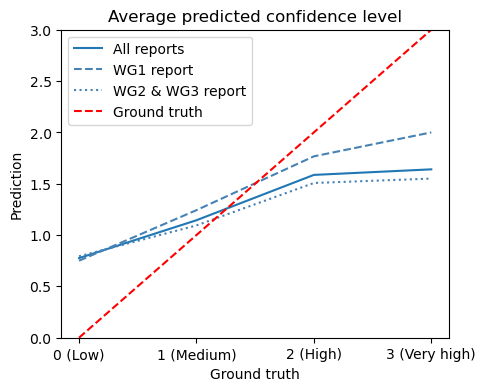

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data

# Extract labels and values from the data dictionary
labels = list(scores_all.keys())
values_all = list(scores_all.values())
values_wg1 = list(scores_wg1.values())
values_wg23 = list(scores_wg23.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

plt.figure(figsize=(5, 4))

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values_all, label='All reports')
sns.lineplot(x=labels, y=values_wg1, linestyle='--', color="steelblue", label='WG1 report')
sns.lineplot(x=labels, y=values_wg23, linestyle='dotted', color="steelblue", label='WG2 & WG3 report')


# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted confidence level")
plt.xlabel("Ground truth")
plt.ylabel("Prediction")


# Show the legend
plt.legend()

# Show the plot
plt.savefig("gpt3.5-fewshot.png", dpi=500)
plt.show()